In [1]:
TRAINING_SET_SIZE = 10000

In [2]:
! pip3 install matplotlib
! pip3 install tensorflow-addons
! pip3 install pandas
! pip3 install pendulum
import os
import pendulum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from residualmlp.residual_mlp import ResidualMLP

     |████████████████████████████████| 11.3 MB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 890 kB 24.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.5 MB 21.6 MB/s eta 0:00:01    |███████████████████████▉        | 8.6 MB 21.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 155 kB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 28.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 50
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 5
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

y_train_ohe = tf.one_hot([i[0] for i in y_train], 10)
indexes_for_rows = tf.range(0, y_train.shape[0])
shuffled_indexes = tf.random.shuffle(indexes_for_rows)
selected_indexes = shuffled_indexes[:TRAINING_SET_SIZE]
selected_x_train = x_train[selected_indexes, :, :, :]
selected_y_train_ohe = y_train_ohe.numpy()[selected_indexes, :]

170508288/170498071 [==============================] - 8s 0us/step


2022-01-15 20:23:39.410601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 20:23:39.421297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 20:23:39.422886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 20:23:39.424783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 20:23:39.425402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

2022-01-15 20:23:54.154349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(-0.5, 31.5, 31.5, -0.5)

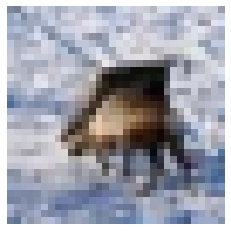

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

In [8]:


resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


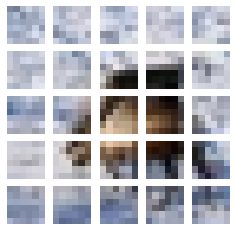

In [9]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [12]:
def create_vit_classifier(vit_base_model_input_shape = (32, 32, 3)):
    
    inputs = layers.Input(shape=vit_base_model_input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # x3 = residual_mlp
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    #features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    
    model = keras.Model(inputs=inputs, outputs=representation)
    return model
    
    #model = keras.Model(inputs=inputs, outputs=logits)
    #return model

In [13]:
base_vit_model = create_vit_classifier()

In [14]:
base_vit_model(x_train[:5])  # (tf.keras.layers.Resizing(600,600)(x_train[:5]))

<tf.Tensor: shape=(5, 1600), dtype=float32, numpy=
array([[ 0.49078047,  0.31151557,  0.64080226, ..., -0.32111868,
        -0.04143965, -1.0459325 ],
       [-0.9078791 , -0.27025563, -0.12527007, ...,  1.4019847 ,
        -0.77094096, -1.1154503 ],
       [-0.15557054,  0.19950968, -1.4693693 , ...,  1.9437548 ,
        -0.62334067, -0.818525  ],
       [ 0.6794414 ,  0.30951262,  0.86282116, ...,  1.2000384 ,
        -0.06587029, -1.4938909 ],
       [-0.10811228,  0.15729457, -0.8868206 , ...,  1.0465517 ,
        -0.8012762 , -1.1354169 ]], dtype=float32)>

In [31]:
res_mlp = ResidualMLP(problem_type = 'classification', #
                      learning_rate = .0007, #
                      input_shape = (32, 32, 3), #(32,32,3), #
                      bw_images = False, #
                      base_model = base_vit_model, #
                      base_model_input_shape = (32, 32, 3),  # (600,600,3), #
                      flatten_after_base_model = False, #
                      blocks = [[7, 75, 8], [5, 75, 10]], #
                      residual_bypass_dense_layers = [[5],[5]], #
                      b_norm_or_dropout_residual_bypass_layers = 'dropout', #
                      dropout_rate_for_bypass_layers = .7, #
                      inter_block_layers_per_block = [10],
                      b_norm_or_dropout_last_layers = 'dropout', # | 'bnorm'
                      dropout_rate = .18, #
                      activation = tf.keras.activations.relu, #
                      final_dense_layers = [15], #
                      number_of_classes = 10, # 1 if a regression problem
                      # final_activation = tf.keras.activations.softmax, #
                      #loss = tf.keras.losses.CategoricalCrossentropy(
                      #    from_logits=False)
                     )
final_residual_mlp = res_mlp.make_tandem_model()

In [32]:
final_residual_mlp.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_4 (Resizing)           (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1600)         424711      resizing_4[0][0]                 
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 75)           120075      model[3][0]                      
____________________________________________________________________________________________

In [17]:
# Let's verify that this beast can accept inputs and return a valid response ...

final_residual_mlp(x_train[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.10273835, 0.09462484, 0.11345865, 0.10274917, 0.0954433 ,
        0.10432092, 0.0917118 , 0.0904271 , 0.10610111, 0.09842474],
       [0.10179009, 0.09696132, 0.10791425, 0.10176654, 0.09721432,
        0.10260683, 0.09503028, 0.09471188, 0.10353538, 0.09846909],
       [0.10076949, 0.09834578, 0.10458307, 0.10085841, 0.09890838,
        0.10158468, 0.09654684, 0.09591466, 0.10247664, 0.10001197],
       [0.09859677, 0.10026058, 0.10389564, 0.09764789, 0.10367682,
        0.10235808, 0.09706433, 0.09413392, 0.09869064, 0.1036753 ],
       [0.09984931, 0.09991741, 0.10268176, 0.09880993, 0.10167672,
        0.10123231, 0.0984302 , 0.09703466, 0.09952668, 0.10084097]],
      dtype=float32)>

In [33]:

date = pendulum.now().__str__()[:16].replace("T","_").replace(":","_")

RESULTS_DIR = f'vit-ResidualMLP-image-classifier_{date}'
PATIENCE = 25
PATIENCE_MIN_DELTA = 0.00001
BATCH_SIZE = 50
EPOCHS = 100

logdir = os.path.join("logs", RESULTS_DIR + "_TB")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = final_residual_mlp.fit(
    x=selected_x_train,
    y=selected_y_train_ohe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose="auto",
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=PATIENCE,
            min_delta=PATIENCE_MIN_DELTA,
            restore_best_weights=True,
        ),
        tensorboard_callback,
    ],
    validation_split=0.3,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=10,
    validation_freq=1,
    max_queue_size=10,
    workers=5,
    use_multiprocessing=True,
)

2022-01-15 20:44:50.587547: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-15 20:44:50.587600: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2022-01-15 20:44:50.987569: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-15 20:44:50.987780: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/100
  1/140 [..............................] - ETA: 24:58 - loss: 2.5881 - top_1_categorical_accuracy: 0.0400 - top_2_categorical_accuracy: 0.1200 - top_3_categorical_accuracy: 0.2600 - top_4_categorical_accuracy: 0.4400 - top_5_categorical_accuracy: 0.5200 - top_6_categorical_accuracy: 0.5800 - top_7_categorical_accuracy: 0.7200 - top_8_categorical_accuracy: 0.8200 - top_9_categorical_accuracy: 0.9400 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - accuracy: 0.0000e+00

2022-01-15 20:45:02.247746: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-15 20:45:02.247810: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/140 [..............................] - ETA: 1:20 - loss: 2.6269 - top_1_categorical_accuracy: 0.0700 - top_2_categorical_accuracy: 0.1300 - top_3_categorical_accuracy: 0.2300 - top_4_categorical_accuracy: 0.4100 - top_5_categorical_accuracy: 0.5200 - top_6_categorical_accuracy: 0.5900 - top_7_categorical_accuracy: 0.7100 - top_8_categorical_accuracy: 0.8200 - top_9_categorical_accuracy: 0.9300 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - accuracy: 0.0000e+00 

2022-01-15 20:45:03.173616: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-15 20:45:03.178188: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-15 20:45:03.244020: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3462 callback api events and 3479 activity events. 
2022-01-15 20:45:03.345025: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-15 20:45:03.470857: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03

2022-01-15 20:45:03.532069: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03/nglsh0r8yv.trace.json.gz


  5/140 [>.............................] - ETA: 1:07 - loss: 2.6185 - top_1_categorical_accuracy: 0.0760 - top_2_categorical_accuracy: 0.1600 - top_3_categorical_accuracy: 0.2680 - top_4_categorical_accuracy: 0.4080 - top_5_categorical_accuracy: 0.5200 - top_6_categorical_accuracy: 0.6000 - top_7_categorical_accuracy: 0.7000 - top_8_categorical_accuracy: 0.8280 - top_9_categorical_accuracy: 0.9440 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - accuracy: 0.0000e+00

2022-01-15 20:45:03.693560: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03

2022-01-15 20:45:03.701396: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03/nglsh0r8yv.memory_profile.json.gz
2022-01-15 20:45:03.722151: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03
Dumped tool data for xplane.pb to logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03/nglsh0r8yv.xplane.pb
Dumped tool data for overview_page.pb to logs/vit-ResidualMLP-image-classifier_2022-01-15_20_44_TB/train/plugins/profile/2022_01_15_20_45_03/nglsh0r8yv

140/140 [==============================] - 21s 72ms/step - loss: 2.4344 - top_1_categorical_accuracy: 0.1136 - top_2_categorical_accuracy: 0.2143 - top_3_categorical_accuracy: 0.3139 - top_4_categorical_accuracy: 0.4136 - top_5_categorical_accuracy: 0.5141 - top_6_categorical_accuracy: 0.6123 - top_7_categorical_accuracy: 0.7124 - top_8_categorical_accuracy: 0.8093 - top_9_categorical_accuracy: 0.9089 - precision_3: 0.1639 - recall_3: 0.0014 - accuracy: 0.0000e+00 - val_loss: 2.3054 - val_top_1_categorical_accuracy: 0.0807 - val_top_2_categorical_accuracy: 0.1730 - val_top_3_categorical_accuracy: 0.2740 - val_top_4_categorical_accuracy: 0.3757 - val_top_5_categorical_accuracy: 0.4863 - val_top_6_categorical_accuracy: 0.5933 - val_top_7_categorical_accuracy: 0.6920 - val_top_8_categorical_accuracy: 0.8250 - val_top_9_categorical_accuracy: 0.9153 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
140/140 [==============================] - 7s 5

Epoch 10/100
140/140 [==============================] - 7s 50ms/step - loss: 1.8471 - top_1_categorical_accuracy: 0.2954 - top_2_categorical_accuracy: 0.5059 - top_3_categorical_accuracy: 0.6376 - top_4_categorical_accuracy: 0.7409 - top_5_categorical_accuracy: 0.8211 - top_6_categorical_accuracy: 0.8941 - top_7_categorical_accuracy: 0.9274 - top_8_categorical_accuracy: 0.9543 - top_9_categorical_accuracy: 0.9813 - precision_3: 0.5980 - recall_3: 0.0684 - accuracy: 0.0000e+00 - val_loss: 1.7829 - val_top_1_categorical_accuracy: 0.2990 - val_top_2_categorical_accuracy: 0.5540 - val_top_3_categorical_accuracy: 0.6990 - val_top_4_categorical_accuracy: 0.7930 - val_top_5_categorical_accuracy: 0.8547 - val_top_6_categorical_accuracy: 0.9247 - val_top_7_categorical_accuracy: 0.9497 - val_top_8_categorical_accuracy: 0.9733 - val_top_9_categorical_accuracy: 0.9873 - val_precision_3: 0.5830 - val_recall_3: 0.0503 - val_accuracy: 0.0000e+00
Epoch 11/100
140/140 [==============================] -

Epoch 19/100
140/140 [==============================] - 7s 51ms/step - loss: 1.5450 - top_1_categorical_accuracy: 0.4394 - top_2_categorical_accuracy: 0.6641 - top_3_categorical_accuracy: 0.7707 - top_4_categorical_accuracy: 0.8514 - top_5_categorical_accuracy: 0.8989 - top_6_categorical_accuracy: 0.9383 - top_7_categorical_accuracy: 0.9581 - top_8_categorical_accuracy: 0.9753 - top_9_categorical_accuracy: 0.9896 - precision_3: 0.6594 - recall_3: 0.2060 - accuracy: 0.0000e+00 - val_loss: 1.5525 - val_top_1_categorical_accuracy: 0.4407 - val_top_2_categorical_accuracy: 0.6520 - val_top_3_categorical_accuracy: 0.7647 - val_top_4_categorical_accuracy: 0.8360 - val_top_5_categorical_accuracy: 0.8917 - val_top_6_categorical_accuracy: 0.9373 - val_top_7_categorical_accuracy: 0.9613 - val_top_8_categorical_accuracy: 0.9807 - val_top_9_categorical_accuracy: 0.9890 - val_precision_3: 0.6488 - val_recall_3: 0.2180 - val_accuracy: 0.0000e+00
Epoch 20/100
140/140 [==============================] -

Epoch 28/100
140/140 [==============================] - 7s 51ms/step - loss: 1.3841 - top_1_categorical_accuracy: 0.5030 - top_2_categorical_accuracy: 0.7134 - top_3_categorical_accuracy: 0.8031 - top_4_categorical_accuracy: 0.8694 - top_5_categorical_accuracy: 0.9143 - top_6_categorical_accuracy: 0.9471 - top_7_categorical_accuracy: 0.9667 - top_8_categorical_accuracy: 0.9786 - top_9_categorical_accuracy: 0.9906 - precision_3: 0.7109 - recall_3: 0.2997 - accuracy: 0.0000e+00 - val_loss: 1.9156 - val_top_1_categorical_accuracy: 0.3873 - val_top_2_categorical_accuracy: 0.5537 - val_top_3_categorical_accuracy: 0.6333 - val_top_4_categorical_accuracy: 0.7323 - val_top_5_categorical_accuracy: 0.8040 - val_top_6_categorical_accuracy: 0.8763 - val_top_7_categorical_accuracy: 0.9180 - val_top_8_categorical_accuracy: 0.9547 - val_top_9_categorical_accuracy: 0.9827 - val_precision_3: 0.5462 - val_recall_3: 0.2520 - val_accuracy: 0.0000e+00
Epoch 29/100
140/140 [==============================] -

Epoch 37/100
140/140 [==============================] - 7s 52ms/step - loss: 1.2880 - top_1_categorical_accuracy: 0.5386 - top_2_categorical_accuracy: 0.7526 - top_3_categorical_accuracy: 0.8383 - top_4_categorical_accuracy: 0.8930 - top_5_categorical_accuracy: 0.9316 - top_6_categorical_accuracy: 0.9596 - top_7_categorical_accuracy: 0.9747 - top_8_categorical_accuracy: 0.9851 - top_9_categorical_accuracy: 0.9939 - precision_3: 0.7288 - recall_3: 0.3513 - accuracy: 0.0000e+00 - val_loss: 1.4281 - val_top_1_categorical_accuracy: 0.5140 - val_top_2_categorical_accuracy: 0.7183 - val_top_3_categorical_accuracy: 0.8033 - val_top_4_categorical_accuracy: 0.8637 - val_top_5_categorical_accuracy: 0.9047 - val_top_6_categorical_accuracy: 0.9437 - val_top_7_categorical_accuracy: 0.9603 - val_top_8_categorical_accuracy: 0.9763 - val_top_9_categorical_accuracy: 0.9900 - val_precision_3: 0.6571 - val_recall_3: 0.3890 - val_accuracy: 0.0000e+00
Epoch 38/100
140/140 [==============================] -

Epoch 46/100
140/140 [==============================] - 7s 52ms/step - loss: 1.2371 - top_1_categorical_accuracy: 0.5663 - top_2_categorical_accuracy: 0.7740 - top_3_categorical_accuracy: 0.8497 - top_4_categorical_accuracy: 0.8984 - top_5_categorical_accuracy: 0.9317 - top_6_categorical_accuracy: 0.9576 - top_7_categorical_accuracy: 0.9740 - top_8_categorical_accuracy: 0.9854 - top_9_categorical_accuracy: 0.9924 - precision_3: 0.7407 - recall_3: 0.3743 - accuracy: 0.0000e+00 - val_loss: 1.4925 - val_top_1_categorical_accuracy: 0.4920 - val_top_2_categorical_accuracy: 0.7093 - val_top_3_categorical_accuracy: 0.7970 - val_top_4_categorical_accuracy: 0.8683 - val_top_5_categorical_accuracy: 0.9113 - val_top_6_categorical_accuracy: 0.9437 - val_top_7_categorical_accuracy: 0.9640 - val_top_8_categorical_accuracy: 0.9797 - val_top_9_categorical_accuracy: 0.9893 - val_precision_3: 0.6280 - val_recall_3: 0.3827 - val_accuracy: 0.0000e+00
Epoch 47/100
140/140 [==============================] -

Epoch 55/100
140/140 [==============================] - 7s 52ms/step - loss: 1.1745 - top_1_categorical_accuracy: 0.5946 - top_2_categorical_accuracy: 0.7919 - top_3_categorical_accuracy: 0.8647 - top_4_categorical_accuracy: 0.9116 - top_5_categorical_accuracy: 0.9424 - top_6_categorical_accuracy: 0.9659 - top_7_categorical_accuracy: 0.9793 - top_8_categorical_accuracy: 0.9870 - top_9_categorical_accuracy: 0.9943 - precision_3: 0.7473 - recall_3: 0.4220 - accuracy: 0.0000e+00 - val_loss: 1.3838 - val_top_1_categorical_accuracy: 0.5447 - val_top_2_categorical_accuracy: 0.7303 - val_top_3_categorical_accuracy: 0.8120 - val_top_4_categorical_accuracy: 0.8727 - val_top_5_categorical_accuracy: 0.9163 - val_top_6_categorical_accuracy: 0.9517 - val_top_7_categorical_accuracy: 0.9677 - val_top_8_categorical_accuracy: 0.9837 - val_top_9_categorical_accuracy: 0.9940 - val_precision_3: 0.6790 - val_recall_3: 0.4103 - val_accuracy: 0.0000e+00
Epoch 56/100
140/140 [==============================] -

Epoch 64/100
140/140 [==============================] - 7s 51ms/step - loss: 1.1004 - top_1_categorical_accuracy: 0.6257 - top_2_categorical_accuracy: 0.8051 - top_3_categorical_accuracy: 0.8764 - top_4_categorical_accuracy: 0.9219 - top_5_categorical_accuracy: 0.9490 - top_6_categorical_accuracy: 0.9673 - top_7_categorical_accuracy: 0.9807 - top_8_categorical_accuracy: 0.9903 - top_9_categorical_accuracy: 0.9966 - precision_3: 0.7708 - recall_3: 0.4689 - accuracy: 0.0000e+00 - val_loss: 1.3665 - val_top_1_categorical_accuracy: 0.5603 - val_top_2_categorical_accuracy: 0.7310 - val_top_3_categorical_accuracy: 0.8177 - val_top_4_categorical_accuracy: 0.8770 - val_top_5_categorical_accuracy: 0.9227 - val_top_6_categorical_accuracy: 0.9480 - val_top_7_categorical_accuracy: 0.9637 - val_top_8_categorical_accuracy: 0.9787 - val_top_9_categorical_accuracy: 0.9897 - val_precision_3: 0.6894 - val_recall_3: 0.4490 - val_accuracy: 0.0000e+00
Epoch 65/100
140/140 [==============================] -

Epoch 73/100
140/140 [==============================] - 7s 49ms/step - loss: 1.0360 - top_1_categorical_accuracy: 0.6527 - top_2_categorical_accuracy: 0.8251 - top_3_categorical_accuracy: 0.8931 - top_4_categorical_accuracy: 0.9291 - top_5_categorical_accuracy: 0.9554 - top_6_categorical_accuracy: 0.9721 - top_7_categorical_accuracy: 0.9827 - top_8_categorical_accuracy: 0.9910 - top_9_categorical_accuracy: 0.9956 - precision_3: 0.7835 - recall_3: 0.5184 - accuracy: 0.0000e+00 - val_loss: 1.4400 - val_top_1_categorical_accuracy: 0.5613 - val_top_2_categorical_accuracy: 0.7337 - val_top_3_categorical_accuracy: 0.8157 - val_top_4_categorical_accuracy: 0.8733 - val_top_5_categorical_accuracy: 0.9120 - val_top_6_categorical_accuracy: 0.9407 - val_top_7_categorical_accuracy: 0.9620 - val_top_8_categorical_accuracy: 0.9740 - val_top_9_categorical_accuracy: 0.9877 - val_precision_3: 0.6602 - val_recall_3: 0.4753 - val_accuracy: 0.0000e+00
Epoch 74/100
140/140 [==============================] -

Epoch 82/100
140/140 [==============================] - 7s 53ms/step - loss: 0.9865 - top_1_categorical_accuracy: 0.6737 - top_2_categorical_accuracy: 0.8354 - top_3_categorical_accuracy: 0.8919 - top_4_categorical_accuracy: 0.9324 - top_5_categorical_accuracy: 0.9549 - top_6_categorical_accuracy: 0.9717 - top_7_categorical_accuracy: 0.9823 - top_8_categorical_accuracy: 0.9891 - top_9_categorical_accuracy: 0.9946 - precision_3: 0.7906 - recall_3: 0.5393 - accuracy: 0.0000e+00 - val_loss: 1.3932 - val_top_1_categorical_accuracy: 0.5590 - val_top_2_categorical_accuracy: 0.7410 - val_top_3_categorical_accuracy: 0.8247 - val_top_4_categorical_accuracy: 0.8837 - val_top_5_categorical_accuracy: 0.9260 - val_top_6_categorical_accuracy: 0.9520 - val_top_7_categorical_accuracy: 0.9670 - val_top_8_categorical_accuracy: 0.9817 - val_top_9_categorical_accuracy: 0.9917 - val_precision_3: 0.6636 - val_recall_3: 0.4827 - val_accuracy: 0.0000e+00
Epoch 83/100
140/140 [==============================] -

140/140 [==============================] - 7s 50ms/step - loss: 0.9672 - top_1_categorical_accuracy: 0.6759 - top_2_categorical_accuracy: 0.8397 - top_3_categorical_accuracy: 0.8987 - top_4_categorical_accuracy: 0.9350 - top_5_categorical_accuracy: 0.9583 - top_6_categorical_accuracy: 0.9730 - top_7_categorical_accuracy: 0.9837 - top_8_categorical_accuracy: 0.9909 - top_9_categorical_accuracy: 0.9976 - precision_3: 0.8023 - recall_3: 0.5570 - accuracy: 0.0000e+00 - val_loss: 1.4521 - val_top_1_categorical_accuracy: 0.5497 - val_top_2_categorical_accuracy: 0.7307 - val_top_3_categorical_accuracy: 0.8183 - val_top_4_categorical_accuracy: 0.8720 - val_top_5_categorical_accuracy: 0.9173 - val_top_6_categorical_accuracy: 0.9410 - val_top_7_categorical_accuracy: 0.9600 - val_top_8_categorical_accuracy: 0.9787 - val_top_9_categorical_accuracy: 0.9913 - val_precision_3: 0.6592 - val_recall_3: 0.4527 - val_accuracy: 0.0000e+00
Epoch 91/100
140/140 [==============================] - 7s 50ms/step

In [34]:
hy = pd.DataFrame(history.history)

In [35]:
hy

,loss,top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy,top_4_categorical_accuracy,top_5_categorical_accuracy,top_6_categorical_accuracy,top_7_categorical_accuracy,top_8_categorical_accuracy,top_9_categorical_accuracy,...,val_top_3_categorical_accuracy,val_top_4_categorical_accuracy,val_top_5_categorical_accuracy,val_top_6_categorical_accuracy,val_top_7_categorical_accuracy,val_top_8_categorical_accuracy,val_top_9_categorical_accuracy,val_precision_3,val_recall_3,val_accuracy
0,2.434435,0.113571,0.214286,0.313857,0.413571,0.514143,0.612286,0.712429,0.809286,0.908857,...,0.274000,0.375667,0.486333,0.593333,0.692000,0.825000,0.915333,0.000000,0.000000,0.0
1,2.349118,0.104571,0.202857,0.303571,0.405286,0.508000,0.604143,0.702714,0.801571,0.900429,...,0.348000,0.461333,0.559667,0.651667,0.741000,0.833333,0.921667,0.000000,0.000000,0.0
2,2.305942,0.113143,0.216429,0.332000,0.430000,0.528429,0.625714,0.724571,0.819286,0.914286,...,0.327667,0.433000,0.547667,0.642000,0.738000,0.824000,0.915667,0.000000,0.000000,0.0
3,2.262347,0.136571,0.255857,0.367429,0.472143,0.566571,0.664571,0.760143,0.851000,0.926286,...,0.309333,0.386000,0.458667,0.576667,0.672333,0.794667,0.906333,0.002907,0.000333,0.0
4,2.196239,0.158429,0.300429,0.421286,0.532714,0.633286,0.726571,0.809286,0.884714,0.943857,...,0.458333,0.572000,0.687333,0.790333,0.841667,0.901667,0.958333,0.750000,0.002000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.910374,0.694857,0.848286,0.907714,0.940571,0.962714,0.976714,0.985714,0.991714,0.996429,...,0.815000,0.875000,0.919333,0.945000,0.962333,0.975000,0.991333,0.643700,0.454667,0.0
93,0.923665,0.695571,0.847429,0.908571,0.943429,0.961571,0.977143,0.985000,0.991429,0.996000,...,0.823333,0.877333,0.920333,0.947333,0.968333,0.982333,0.993000,0.664132,0.495000,0.0
94,0.890936,0.706571,0.859571,0.914000,0.944143,0.966286,0.980429,0.986714,0.991000,0.996286,...,0.831000,0.887667,0.928333,0.952667,0.968667,0.983667,0.991333,0.680465,0.487667,0.0
95,0.913805,0.696286,0.853714,0.909857,0.947714,0.964857,0.977714,0.986429,0.991714,0.996571,...,0.818000,0.876333,0.918667,0.946333,0.967667,0.981000,0.991333,0.635330,0.484333,0.0


In [36]:
hy.to_csv(f'{date}_test_history.csv')

In [37]:
hy.to_json(f'{date}_test_history.json')

In [38]:
hy.columns

Index(['loss', 'top_1_categorical_accuracy', 'top_2_categorical_accuracy',
       'top_3_categorical_accuracy', 'top_4_categorical_accuracy',
       'top_5_categorical_accuracy', 'top_6_categorical_accuracy',
       'top_7_categorical_accuracy', 'top_8_categorical_accuracy',
       'top_9_categorical_accuracy', 'precision_3', 'recall_3', 'accuracy',
       'val_loss', 'val_top_1_categorical_accuracy',
       'val_top_2_categorical_accuracy', 'val_top_3_categorical_accuracy',
       'val_top_4_categorical_accuracy', 'val_top_5_categorical_accuracy',
       'val_top_6_categorical_accuracy', 'val_top_7_categorical_accuracy',
       'val_top_8_categorical_accuracy', 'val_top_9_categorical_accuracy',
       'val_precision_3', 'val_recall_3', 'val_accuracy'],
      dtype='object')

<AxesSubplot:>

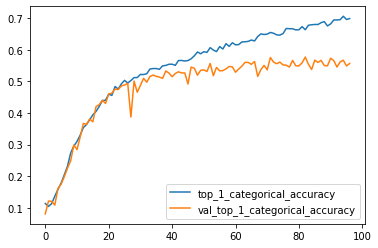

In [39]:
hy[['top_1_categorical_accuracy','val_top_1_categorical_accuracy']].plot()

# A little better, but still was not a great run. Things to try:
1. Continue optimizing transformer_layers. 
2. First try bnorm in the main block of Dense layers. The diminishing gradient over epochs may be a sign of internal covariate shift.
3. Try a less complex model:
    1. Try fewer layers per block 
    2. Smaller layers in blocks
    3. Less Dense units on residual bypass
4. Optimize learning rate 
5. Start with a suitable pre-trained vision transformer as a base model.

In [40]:
hy[['top_1_categorical_accuracy','val_top_1_categorical_accuracy']].max()

top_1_categorical_accuracy        0.706571
val_top_1_categorical_accuracy    0.577333
dtype: float64

In [41]:
model_name = f"{date}_exported_model"
final_residual_mlp.save(model_name)

INFO:tensorflow:Assets written to: 2022-01-15_20_44_exported_model/assets


INFO:tensorflow:Assets written to: 2022-01-15_20_44_exported_model/assets
/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
# a quick test for Flatten = True:
test_flatten_res_mlp = ResidualMLP(problem_type = 'classification', #
                      learning_rate = .0007, #
                      input_shape = (32, 32, 3), #(32,32,3), #
                      bw_images = False, #
                      base_model = '',
                      base_model_input_shape = (32, 32, 3),  # (600,600,3), #
                      flatten_after_base_model = True, #
                      blocks = [[7, 75, 8], [5, 75, 10]], #
                      residual_bypass_dense_layers = [[5],[5]], #
                      b_norm_or_dropout_residual_bypass_layers = 'dropout', #
                      dropout_rate_for_bypass_layers = .7, #
                      inter_block_layers_per_block = [10],
                      b_norm_or_dropout_last_layers = 'dropout', # | 'bnorm'
                      dropout_rate = .18, #
                      activation = tf.keras.activations.relu, #
                      final_dense_layers = [15], #
                      number_of_classes = 10, # 1 if a regression problem
                      # final_activation = tf.keras.activations.softmax, #
                      #loss = tf.keras.losses.CategoricalCrossentropy(
                      #    from_logits=False)
                     )
test_flatten_model = test_flatten_res_mlp.make_tandem_model()


In [46]:
test_flatten_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_6 (Resizing)           (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1600)         424711      resizing_6[0][0]                 
__________________________________________________________________________________________________
dense_106 (Dense)               (None, 75)           120075      model[5][0]                      
____________________________________________________________________________________________